In [4]:
from sklearn.model_selection import train_test_split
from sklearn import datasets, svm
import numpy as np
from math import sqrt
from shapleycomposition import ShapleyExplainer
from composition_stats import ilr, ilr_inv, sbp_basis, inner
from bifurc_tree import create_tree_from_sbp, init_graph, build_graph
import plotly.graph_objects as go

In [9]:
K = 13         #index of the instance you want to test in the test set
N_class = 3    #number of class, the dimension of the simplex is therefore N_class-1


#load the dataset and split into a training and testing set
data = datasets.load_iris()
(X, Y) = (data.data, data.target)
X_train,X_test,Y_train,Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

#train an SVM classifier
svc_linear = svm.SVC(kernel='rbf', probability=True)
svc_linear.fit(X_train, Y_train)

#choose an Aitchison orthonormal basis by setting a sequential binary partition matrix.
#If None, the basis obtained with the gram-schmidt procedure is used
sbpmatrix=np.array([[1,-1,0],[1,1,-1]])
basis = sbp_basis(sbpmatrix)

# explain all the predictions in the test set
explainer = ShapleyExplainer(svc_linear.predict_proba, X_train, N_class, sbpmatrix=sbpmatrix,
                            names_classes=data.target_names,
                            names_features=['sep. length','sep. width','pet. length','pet. width'])
(shapley, base) = explainer.explain_instance(np.array(X_test[K]))

print("True label of the tested instance: ", end="")
print(data.target_names[Y_test[K]])

#get the model prediction for the Kth instance of the test partition
pred = svc_linear.predict_proba(X_test[K].reshape(1,-1))
print("Prediction on the simplex: ",end="")
print(pred)
ilr_pred = ilr(pred, basis=basis)
print("Prediction in the ILR space: ",end="")
print(ilr_pred)

#The sum of the base distribution and the shapley composition in the ILR space is equal to the predicted probability distribution
sum_shap_base = np.array(shapley).sum(axis=0)+base
print("Sum of the shapley composition and the base distribution in the ILR space: ", end="")
print(sum_shap_base)



True label of the tested instance: versicolor
Prediction on the simplex: [[0.00799086 0.83667646 0.15533268]]
Prediction in the ILR space: [-3.28885226 -0.52394703]
Sum of the shapley composition and the base distribution in the ILR space: [-3.28885225 -0.52394706]


In [3]:
#SUMMARIZE WITH NORM, COSINE AND INNER PRODUCTS

(norm_shapley, proj_shap_class, cos_shap_shap) = explainer.summarize()

List of the features sorted by their Shapley strength (norm of their Shapley composition):
	 pet. length: 2.2009905
	 pet. width: 0.5133496
	 sep. length: 0.1288879
	 sep. width: 0.1089083

Projection of the Shapley compositions on the class vectors:
		sep. length	sep. width	pet. length	pet. width	
setosa:   	-0.0812375	-0.1072735	-1.9142413	-0.5119441	
versicolor:	0.1272757	0.0373557	1.8978808	0.2888474	
virginica:	-0.0460382	0.0699178	0.0163604	0.2230967	

Cosine between each Shapley compositions:
		sep. length	sep. width	pet. length	pet. width	
sep. length:	1.0000000	0.4868197	0.9313487	0.6859799	
sep. width:	0.4868197	1.0000000	0.7714660	0.9695268	
pet. length:	0.9313487	0.7714660	1.0000000	0.9038339	
pet. width:	0.6859799	0.9695268	0.9038339	1.0000000	


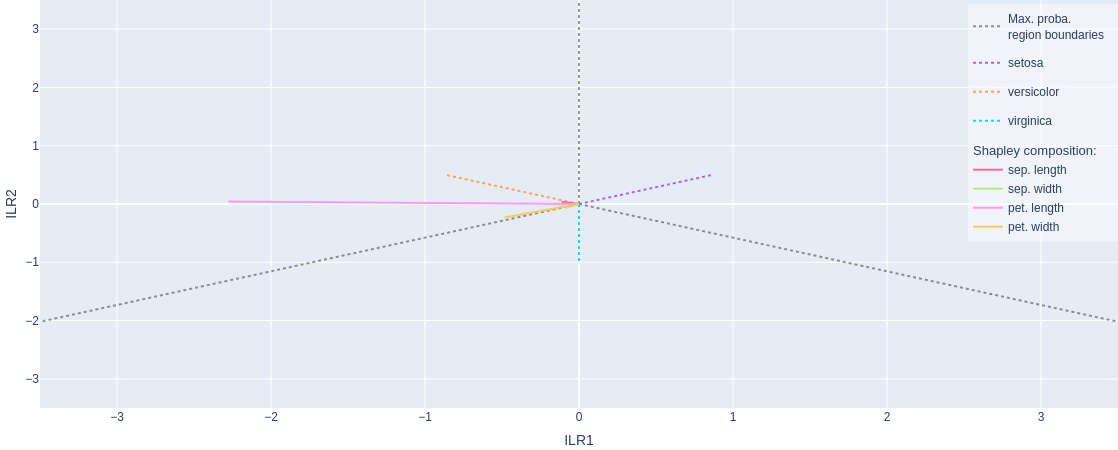

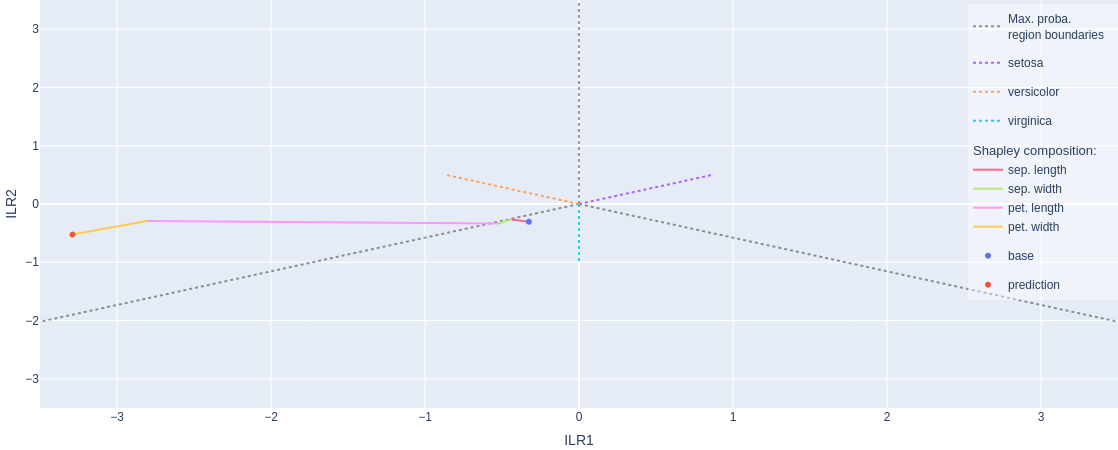

In [11]:
#PLOT the 2D ILR SPACE (CORRESPONDING TO THE CHOSEN ILR COMPONENTS LISTED IN BALANCES).
#plot range [-lim, lim]
#If shapley_sum is True, the sum of the shapley vectors are summed from the base distribution to the prediction

fig = explainer.plot_ilr_space(balances=[1, 2], lim=3.5, figsize=450)

fig = explainer.plot_ilr_space(balances=[1, 2], shapley_sum=True, lim=3.5, figsize=450)


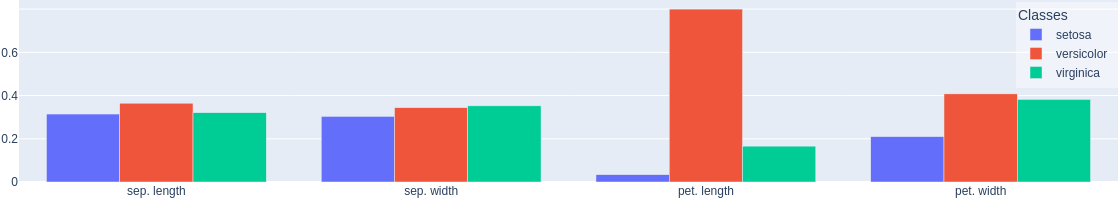

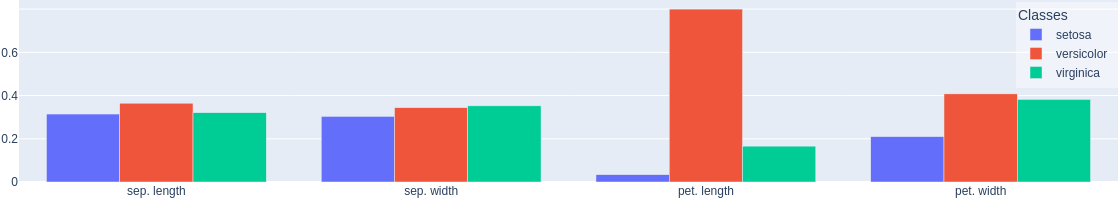

In [5]:
#Plot the Shapley compositions as histograms

explainer.shapley_histogram(figheight=200)